# Image Colorization using Optimization

## Imports

In [635]:
%matplotlib inline

import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from colormap.colors import hex2rgb
from colormap.colors import rgb2yuv

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Image

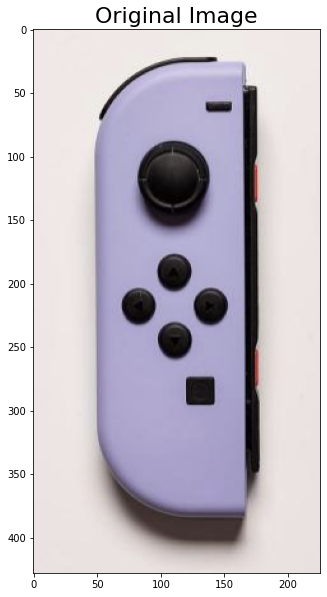

In [1147]:
orig_img = cv2.cvtColor(cv2.imread("images/joycon.jpg"), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.title("Original Image", {'fontsize':22})
plt.imshow(orig_img)

## Convert to Grayscale

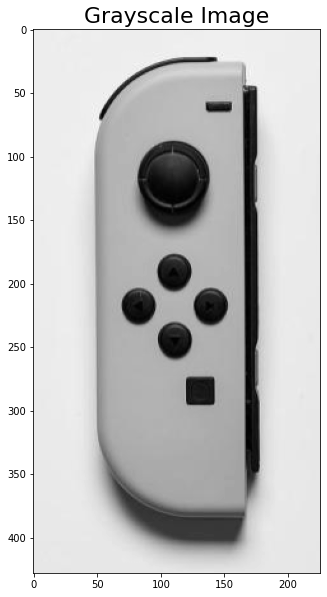

In [1148]:
grayscale_img = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(10, 10))
plt.title("Grayscale Image", {'fontsize':22})
plt.imshow(grayscale_img, cmap='gray')

## UI: Image Colorization Setup

### Step 1: Choose a color

In [1089]:
from IPython import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


color_picker = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='black',
    disabled=False
)
display.display(color_picker)

ColorPicker(value='black', description='Pick a color')

### Step 2: Place Markings

If it doesn't get you to the drawing mode, then rerun this function again.

============================================   NOTICE   ============================================

You do not need to rerun this cell or the last to add another color!
Simply select a new color from the color picker, press ENTER, and click on the figure to plot new colored points.


<IPython.core.display.Javascript object>


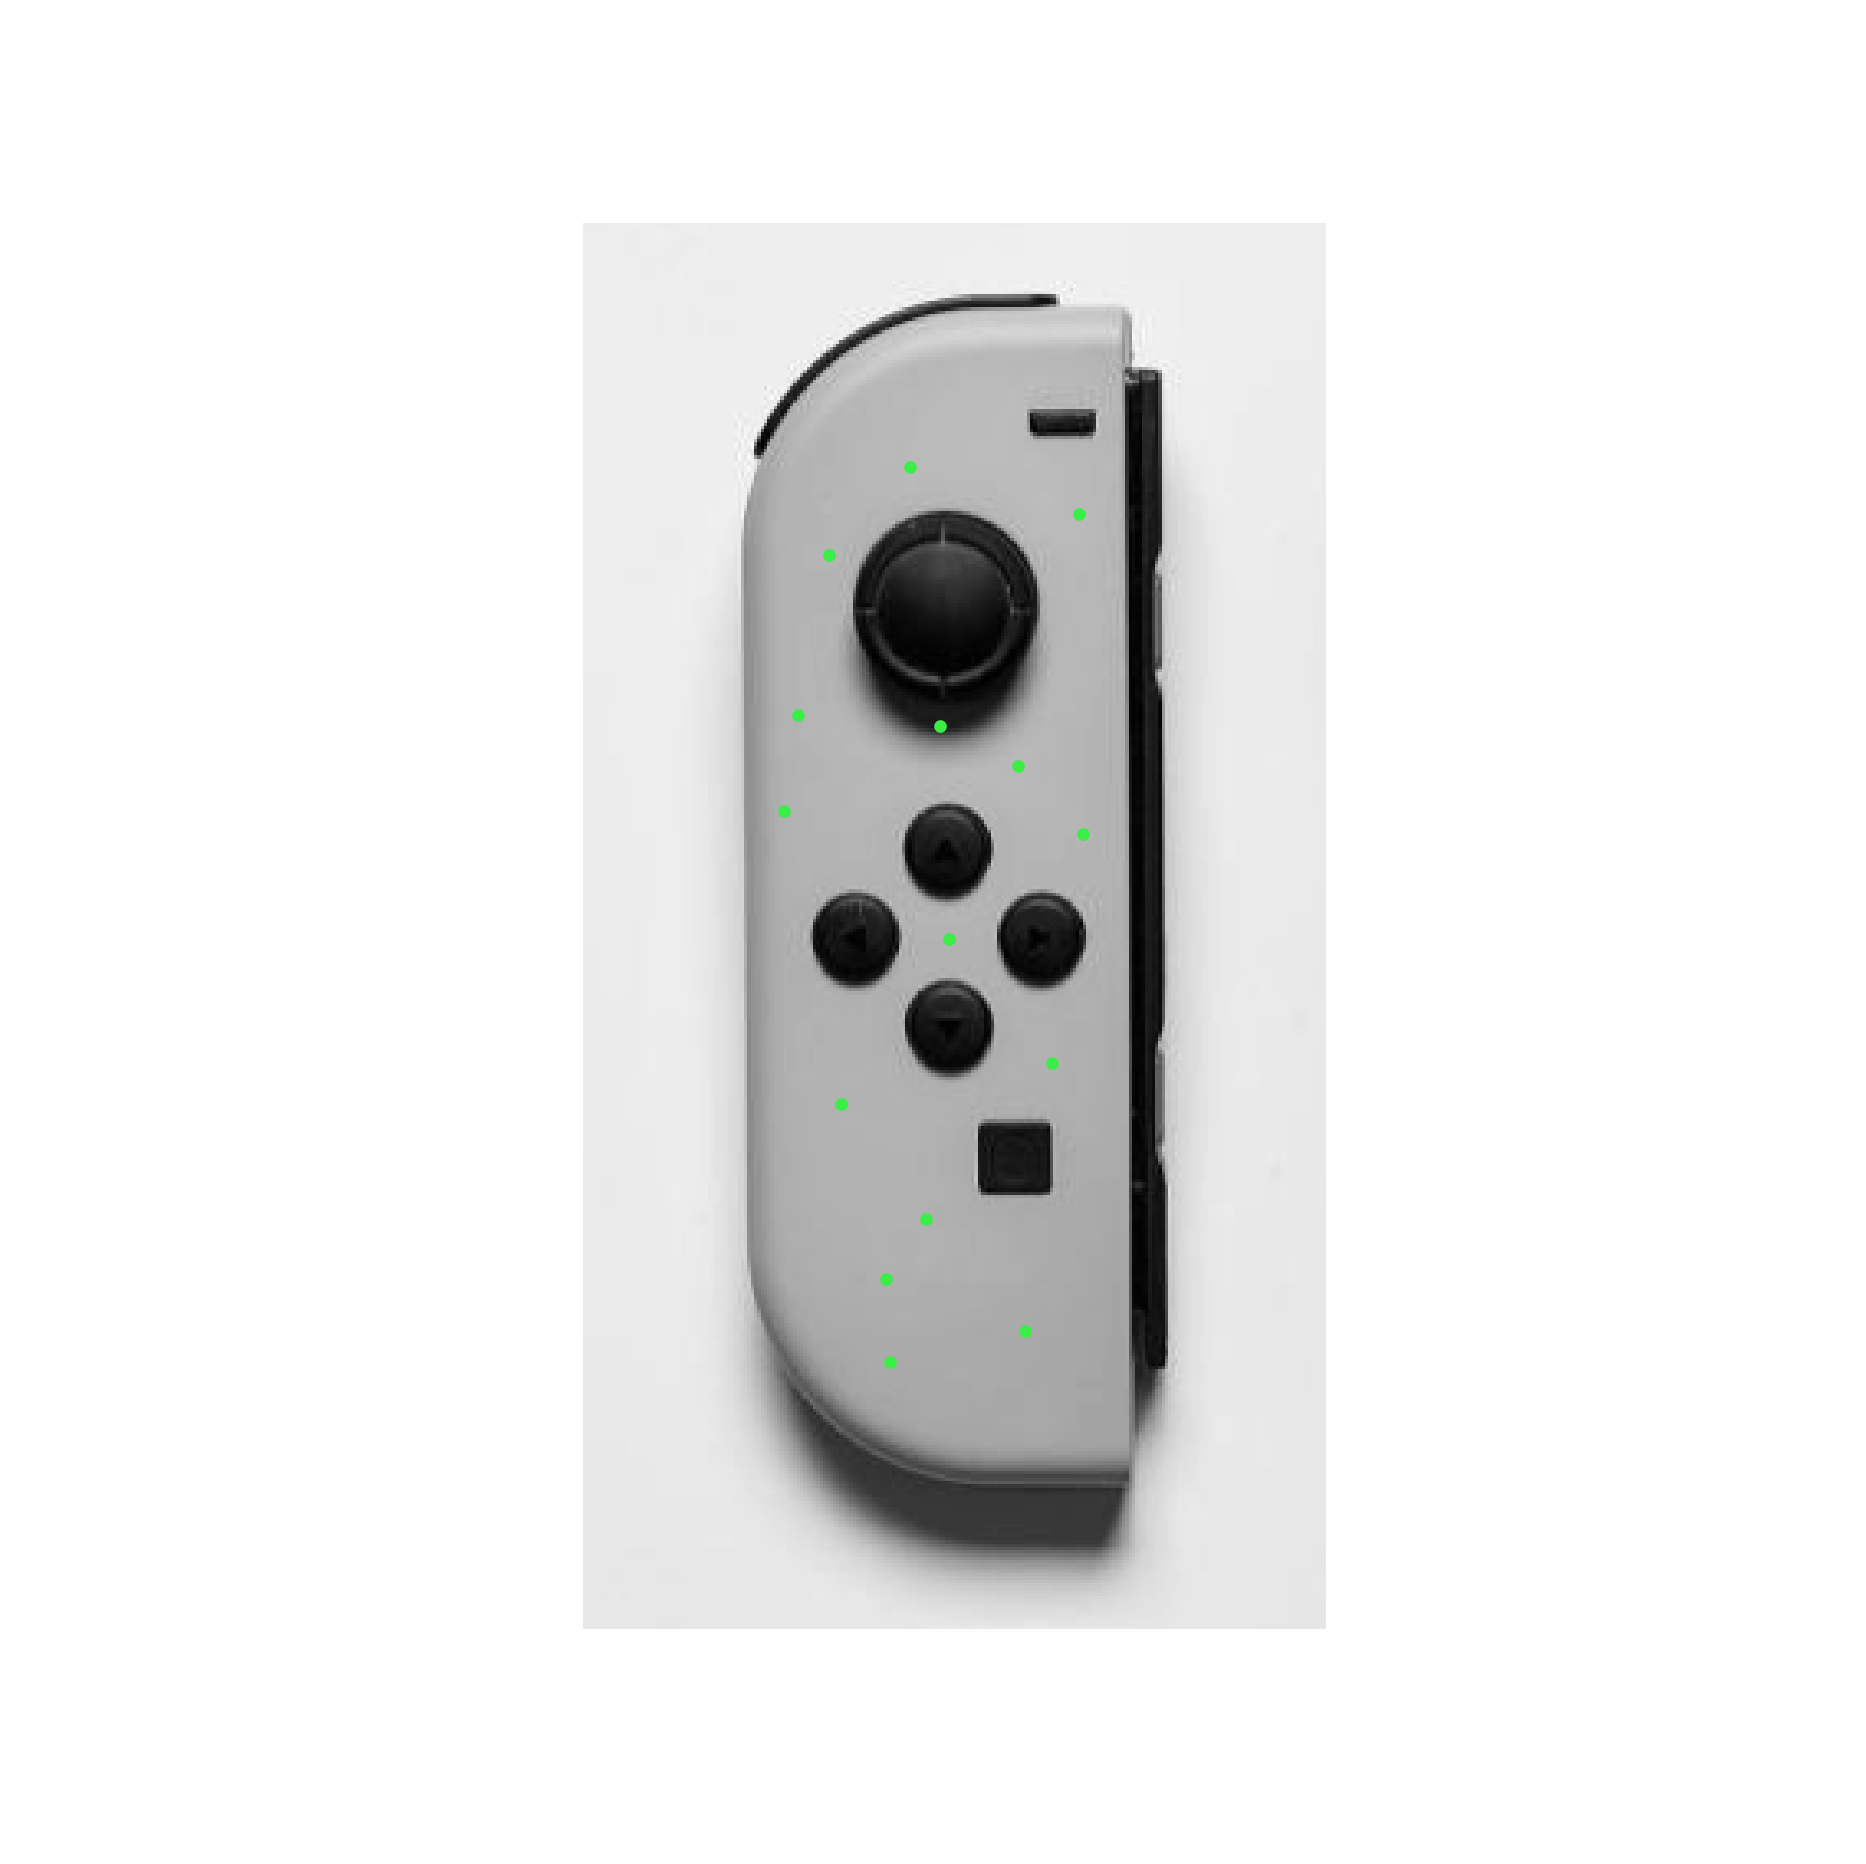

In [1188]:
%matplotlib notebook

my_color = color_picker.value

def mark_image(img):
    print("If it doesn't get you to the drawing mode, then rerun this function again.")
    print("\n============================================   NOTICE   ============================================\n")
    print("You do not need to rerun this cell or the last to add another color!")
    print("Simply select a new color from the color picker, press ENTER, and click on the figure to plot new colored points.")
    fig = plt.figure(figsize = (8, 8))
    fig.set_label('Mark the spots to color')
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plot_points = []

    def on_mouse_pressed(event):
        my_color = color_picker.value
        
        x = event.xdata
        y = event.ydata
        plot_points.append((x, y, my_color))
        plt.plot(x, y, c=my_color, marker='o')
        
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', on_mouse_pressed)

    return plot_points

plot_points = mark_image(grayscale_img)

### Step 3: Add Markings to grayscale image

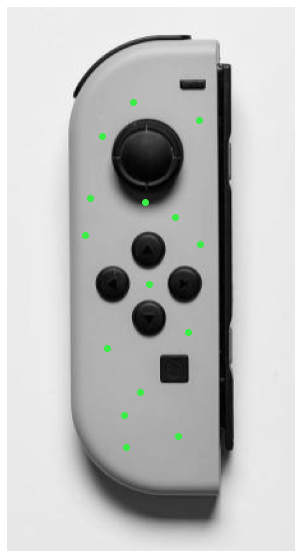

In [1189]:
%matplotlib inline

colored_pixels = []
added_colors = []

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(grayscale_img, cmap='gray')
for pt in plot_points:
    x, y, color = pt
    plt.plot(x, y, c=color, marker='o')
    colored_pixels.append((int(y), int(x)))
    added_colors.append(color)
plt.savefig("output/marked_img.jpg", bbox_inches='tight', pad_inches=0, dpi=500)
marked_img = cv2.cvtColor(cv2.imread("output/marked_img.jpg"), cv2.COLOR_BGR2RGB)

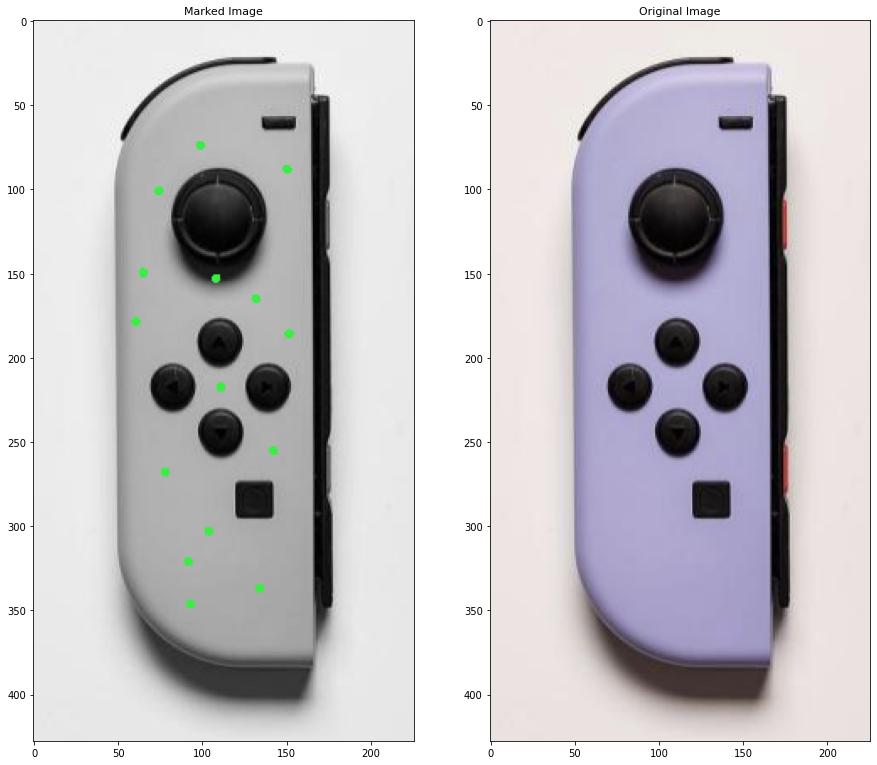

In [1201]:
marked_img = cv2.resize(marked_img, (orig_img.shape[1], orig_img.shape[0]))

fig = plt.figure(figsize=(15, 15))
plt.subplot(122)
plt.title("Original Image", {'fontsize':11})
plt.imshow(orig_img)

plt.subplot(121)
plt.title("Marked Image", {'fontsize':11})
plt.imshow(marked_img)

### Step 5: Restore original intensity values for marked locations

In [1202]:
grayscale_yuv = cv2.cvtColor(grayscale_img, cv2.COLOR_GRAY2RGB)
grayscale_yuv = cv2.cvtColor(grayscale_yuv, cv2.COLOR_RGB2YUV)
yuv_image = cv2.cvtColor(marked_img, cv2.COLOR_RGB2YUV)


final_yuv = np.copy(grayscale_yuv)
for i in range(len(colored_pixels)):
    r, g, b = hex2rgb(added_colors[i], normalise=False)
    y = int(0.299 * r + 0.587 * g + 0.114 * b)
    u = int(-32591.0/221500.0 * r + -63983.0/221500.0 * g + 0.436 * b)
    v = int(0.615 * r + -72201./140200 * g + -7011/70100. * b)
    
    final_yuv[colored_pixels[i][0], colored_pixels[i][1], 1] = int(u * 255)
    final_yuv[colored_pixels[i][0], colored_pixels[i][1], 2] = int(v * 255)



for row in range(yuv_image.shape[0]):
    if row % 50 == 0:
    for col in range(yuv_image.shape[1]):
        yuv_image[row, col, 0] = grayscale_yuv[row, col, 0]
        
fig = plt.figure(figsize=(15, 15))
plt.title("Marked Image w/ Original Intensities", {'fontsize':11})
plt.imshow(cv2.cvtColor(yuv_image, cv2.COLOR_YUV2RGB))
# plt.imshow(cv2.cvtColor(grayscale_yuv, cv2.COLOR_YUV2RGB))

IndentationError: expected an indented block (<ipython-input-1202-b1cee381fce2>, line 20)

In [1203]:
def getWindowPixels(row, col):
    row_start = row - 1
    row_end = row + 2
    col_start = col - 1
    col_end = col + 2

    if row_start < 0:
        row_start = 0 
    if row_end >= height:
        row_end = height
    if col_start < 0:
        col_start = 0 
    if col_end >= width:
        col_end = width
    
    pixels = []
        
    for i in range(row_start, row_end):
        for j in range(col_start, col_end):
            if i != row or j != col:
                pixels.append((i, j))
                
    return pixels

### Step 6: Calculate the variances and means for each pixel window

In [1208]:
variances = np.zeros((yuv_image.shape[0], yuv_image.shape[1]), dtype='uint8')
means = np.zeros(variances.shape, dtype='uint8')

height = variances.shape[0]
width = variances.shape[1]

# Calculate variances and mean for pixel windows
for row in range(height):
    for col in range(width):       
        
        
        window = getWindowPixels(row, col)
        window_y_values = []
        
        for pixel in window:
            window_y_values.append(final_yuv[pixel[0], pixel[1]])
        
        variances[row, col] = np.var(window_y_values)
        means[row, col] = np.mean(window_y_values)
        

### Step 7: Use the variances and means to calculate the weights for each pixel

In [1209]:
weights = {}

for row in range(height):
    for col in range(width):
        neighboring_pixels = getWindowPixels(row, col)
        for pixel in neighboring_pixels:
            y_value = yuv_image[row, col, 0]
            
            weight = 1 + (1 / pow(variances[row, col], 2)) * (final_yuv[row, col, 0] - means[row, col]) * (final_yuv[row, col, 0] - means[pixel[0], pixel[1]])
            
            weights[((row, col), pixel)] = weight
            

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in ubyte_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in long_scalars
  if __name__ == '__main__':


#### Step 7.b: Normalize the weights

In [1211]:
for row in range(height):
    for col in range(width):
        others = getWindowPixels(row, col)
        
        weightSum = 0
        
        for pixel in others:
            toAdd = weights[((row, col), (pixel[0], pixel[1]))]
            if math.isnan(toAdd):
                continue
            weightSum += weights[((row, col), (pixel[0], pixel[1]))]
            
        for pixel in others:
            weights[((row, col), (pixel[0], pixel[1]))] /= weightSum
            



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


### Step 8: Color areas

In [1212]:
def traverseArea(start, final_image):
    toVisit = [start]
    visited = {}
        
    while toVisit:
        point = toVisit.pop()
        
        if point in visited:
            continue
            
        visited[point] = True
        
        window = getWindowPixels(point[0], point[1])
    
        # Remove visited pixels
        for pixel in window:
            if visited.get(pixel) is not None:
                window.remove(pixel)

        minSize = 1 / len(getWindowPixels(point[0], point[1]))
        
        # Transfer color values
        variance_weights = []
        
        counter = 0
        
        for pixel in window:
            weight = weights[((point[0], point[1]), (pixel[0], pixel[1]))]
            
            if weight >= .124:
                counter += 1
            
            variance_weights.append(weight)
            
        neighbor_variance = np.var(variance_weights)
        
        for pixel in window:
            weight = weights[((point[0], point[1]), (pixel[0], pixel[1]))]


            if neighbor_variance < .00000002:
 
                final_image[pixel[0], pixel[1], 1] = final_image[point[0], point[1], 1]
                final_image[pixel[0], pixel[1], 2] = final_image[point[0], point[1], 2]
                toVisit.append(pixel) 
            
            
            if weight > .7 or counter > 6:

                final_image[pixel[0], pixel[1], 1] = final_image[point[0], point[1], 1]
                final_image[pixel[0], pixel[1], 2] = final_image[point[0], point[1], 2]
                toVisit.append(pixel)  




start = (238, 639)
# traverseArea((200, 700))

In [1213]:
copy_final_yuv = np.copy(final_yuv)

for pixel in colored_pixels:   
    traverseArea(pixel, copy_final_yuv)
    


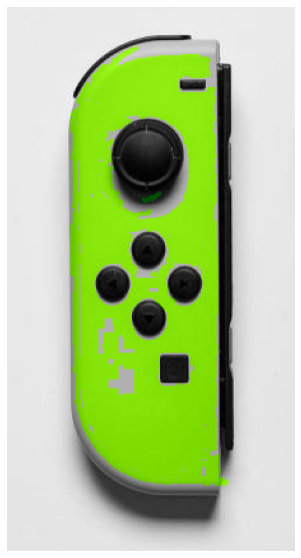

In [1214]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(cv2.cvtColor(copy_final_yuv, cv2.COLOR_YUV2RGB))
plt.savefig("output/colored_image.jpg", bbox_inches='tight', pad_inches=0, dpi=500)
